# Building the Classification model on just the image

In [4]:
# Old installation format

# pip install tensorflow-gpu

# Current installation format

!pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\emman\AppData\Local\Temp\pip-install-y9wyt761\tensorflow-gpu_ec207ae4343d4bbfb7b2d4450906f55f\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-e

In [ ]:
import tensorflow as tf

# Create a TensorFlow session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

# Specify the GPU as the device to be used for computation
with tf.device('/device:GPU:0'):
    # Build and train your model




In [82]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve

import os
import math
import glob
import shutil
import cv2

In [17]:
source_images_folder = os.path.join('.','Dataset',"Train") 
labels = os.listdir(os.path.join('.','Dataset',"Train"))
destination_folder = os.path.join('.',"Dataset",'normal_image')

# Define the training and validation data directory
train_dir = os.path.join(destination_folder, 'train')
val_dir = os.path.join(destination_folder, 'val')

In [8]:
# Split training data to training and validation set

for label in labels:
  img_path = os.path.join(source_images_folder, label)
  images = glob.glob(img_path + '/*.png')
  print("{}: {} Images".format(label, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(train_dir, label)):
      os.makedirs(os.path.join(train_dir, label))
    shutil.copy(t, os.path.join(train_dir, label))

  for v in val:
    if not os.path.exists(os.path.join(val_dir, label)):
      os.makedirs(os.path.join(val_dir, label))
    shutil.copy(v, os.path.join(val_dir, label))

Kidney_stone: 625 Images
Normal: 828 Images


In [18]:
batch_size = 128
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(160,320),
                                               class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(160,320), #(64,64)
                                                              class_mode='binary')

Found 1162 images belonging to 2 classes.
Found 291 images belonging to 2 classes.


### Visualise a training Image

In [19]:
sample_training_images, _ = next(train_data_gen) 

In [20]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

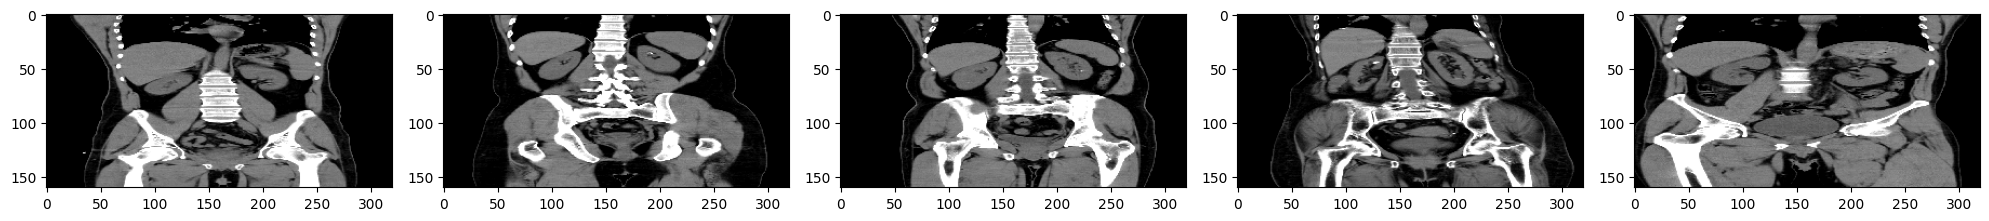

In [21]:
plotImages(sample_training_images[:5])  # Plot images 0-4

Define the Model

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(160, 320, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 318, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 159, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 157, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 76, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 38, 128)      0

In [25]:
EPOCHS = 100
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(1162 / float(batch_size))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(291  / float(batch_size)))
)

Epoch 1/100
10/10 [==============================] - 133s 12s/step - loss: 0.7009 - accuracy: 0.5241 - val_loss: 0.6768 - val_accuracy: 0.5704
Epoch 2/100
10/10 [==============================] - 79s 8s/step - loss: 0.6820 - accuracy: 0.5818 - val_loss: 0.6723 - val_accuracy: 0.5704
Epoch 3/100
10/10 [==============================] - 73s 7s/step - loss: 0.6673 - accuracy: 0.5869 - val_loss: 0.6567 - val_accuracy: 0.5876
Epoch 4/100
10/10 [==============================] - 73s 7s/step - loss: 0.6404 - accuracy: 0.6463 - val_loss: 0.6176 - val_accuracy: 0.6529
Epoch 5/100
10/10 [==============================] - 71s 7s/step - loss: 0.5889 - accuracy: 0.6962 - val_loss: 0.6193 - val_accuracy: 0.6392
Epoch 6/100
10/10 [==============================] - 75s 8s/step - loss: 0.5305 - accuracy: 0.7556 - val_loss: 0.5888 - val_accuracy: 0.6976
Epoch 7/100
10/10 [==============================] - 74s 7s/step - loss: 0.4328 - accuracy: 0.8150 - val_loss: 0.6571 - val_accuracy: 0.7010
Epoch 8/100

## Save Model

In [14]:
tf.keras.models.save_model(
    model,os.path.join(destination_folder,'normal_modelv1.h5')
)

In [11]:
destination_folder

'.\\Dataset\\normal_image'

# Testing Phase


### Learning Curve

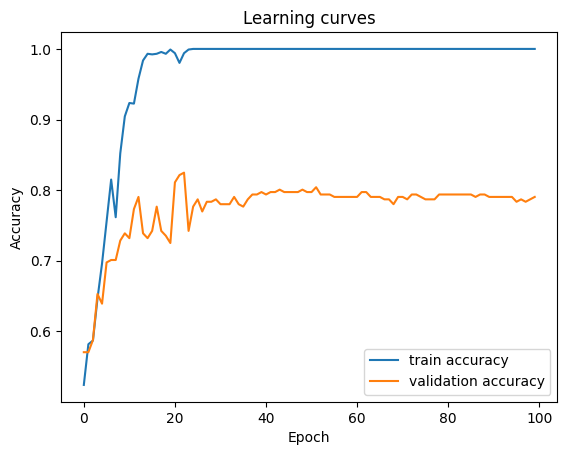

In [29]:
# Plot learning curves
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Learning curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

## Evaluate the model

In [30]:
# Directory to the testing file

test_dir = os.path.join('.','Dataset',"normal_image_test")

In [35]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator_1 = test_datagen.flow_from_directory(
        test_dir,
        target_size=(160,320),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,)

Found 346 images belonging to 2 classes.


3/3 [==============================] - 21s 8s/step


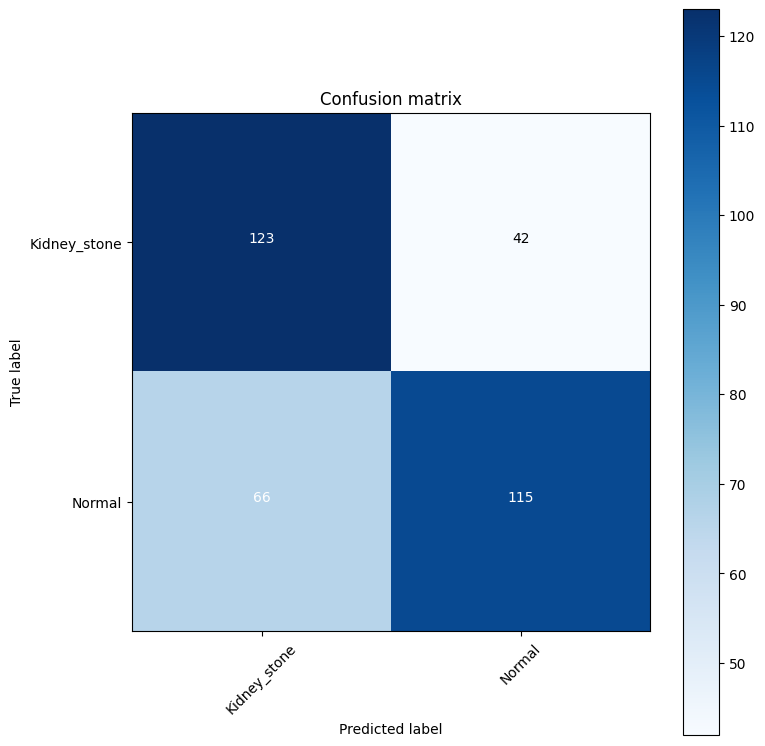

In [75]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools


y_pred = model.predict(test_generator_1)

# Convert predictions to binary values
y_pred_classes = np.round(y_pred)

# define threshold
threshold = 0.5

# Convert the probability scores to class labels based on the threshold
y_pred_classes = (y_pred_classes > threshold).astype(int)

# get the actual label
y_pred_classes = np.array([i.tolist().index(max(i)) for i in y_pred_classes])

# Get the true labels from the generator
y_true = test_generator_1.classes

# Get the class labels
class_labels = list(test_generator_1.class_indices.keys())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

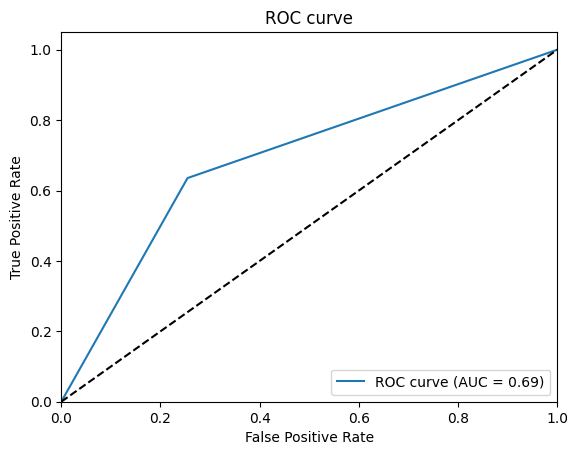

In [77]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_classes)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### Further Evaluation

precision, Recall, accuracy_score, f1_score, precision_recall_curve

In [88]:
## precision_recall_curve

print(f'The model evaluation scores are:\n Precision:{precision_score(y_true, y_pred_classes)}\n Accuracy:{accuracy_score(y_true, y_pred_classes)}\n F1:{f1_score(y_true, y_pred_classes)}\n Recall:{recall_score(y_true, y_pred_classes)}')

The model evaluation scores are:
 Precision:0.732484076433121
 Accuracy:0.6878612716763006
 F1:0.6804733727810651
 Recall:0.6353591160220995


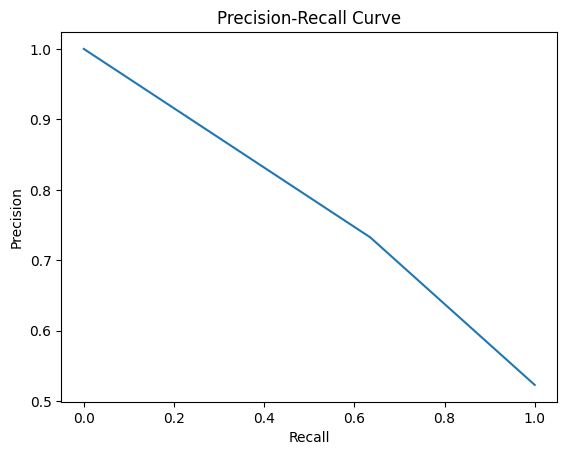

In [90]:
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_classes)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()